In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# 导入数据
iris = datasets.load_iris()
X = iris.data
print("X：", type(X), X.shape, X[:10])
y = iris.target
print("y:", type(y), y.shape, y[:10])

Automatically created module for IPython interactive environment
X： <class 'numpy.ndarray'> (150, 4) [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]
y: <class 'numpy.ndarray'> (150,) [0 0 0 0 0 0 0 0 0 0]


In [2]:
# 将输出二值化
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]
print("二值化后", type(y), y.shape, y[:10])

二值化后 <class 'numpy.ndarray'> (150, 3) [[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [3]:
# 增加一些噪音特征让问题变得更难一些
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

print(type(X), X.shape, X[:10])

<class 'numpy.ndarray'> (150, 804) [[ 5.1         3.5         1.4        ... -1.07709907 -0.4246633
  -0.8299646 ]
 [ 4.9         3.          1.4        ...  1.4121517  -1.38043075
  -0.53591456]
 [ 4.7         3.2         1.3        ...  0.65880214 -0.59691711
  -0.22295918]
 ...
 [ 5.          3.4         1.5        ...  0.34265399 -0.09796724
  -0.24024461]
 [ 4.4         2.9         1.4        ...  0.08055409 -0.18817845
  -1.31119247]
 [ 4.9         3.1         1.5        ... -0.20273458 -0.25786648
   0.07081452]]


In [7]:
# 打乱并分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# 学习，预测
classifier = OneVsRestClassifier(svm.SVC(kernel='linear',
                                         probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
print("预测后：", type(y_score), y_score.shape, y_score[:10])


预测后： <class 'numpy.ndarray'> (75, 3) [[-0.76301132 -0.36482547  0.12386354]
 [-0.20224493 -0.63144366 -0.16612302]
 [ 0.11801481 -0.80263073 -0.32055874]
 [-0.90780855 -0.12395478  0.02199789]
 [-0.01116192 -0.27913475 -0.71889214]
 [-0.6048727  -0.34730509 -0.05859016]
 [ 0.02283491 -0.24506467 -0.79111998]
 [-0.61076876  0.18264917 -0.57199363]
 [-0.37572754 -0.24059516 -0.38933694]
 [-0.47017411 -0.25745136 -0.27510839]]


In [ ]:

# 计算每个类别的ROC曲线和AUC面积
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算ROC曲线和AUC面积的微观平均（micro-averaging）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

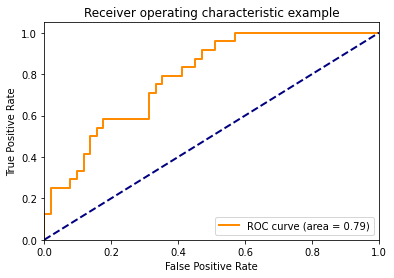

In [2]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<ipython-input-3-d1b9e2f42448>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


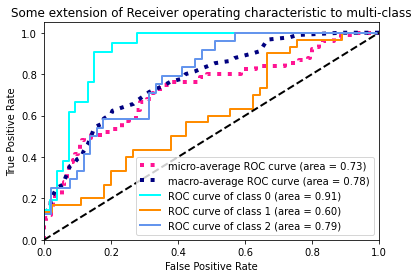

In [3]:
# 首先收集所有的假正率
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# 然后在此点内插所有ROC曲线
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# 最终计算平均和ROC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制全部的ROC曲线
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()